# Segmentação de imagens e predição utilizando redes pré-treinadas:

Este trabalho tem como objetivo principal a utilização da técnica de selective search para reconhecer áreas de interesse em imagens e então fazer predições nestes recortes com redes pré-treinadas.
Neste exemplo estaremos utilizando a vgg19, mas com pequenas alterações no código outras redes podem ser facilmente adaptadas.
<br><br>
1. No primeiro passo faremos uma coleção das funções que iremos utilizar, elas estarão descritas uma a uma.
<br><br>
2. Na sequência vamos fazer o selective search de uma imagem para visualizar o processo e as áreas de interesse.
<br><br>
3. Então fazemos nossas predições nessas áreas de interesse e utilizamos uma função que automatiza o processo do início ao fim.
<br><br>
4. As considerações finais fecham este trabalho com alguns comentários sobre as predições, formas de trabalho e escolha arbitrárias sobre o código.
<br><br>
Mãos a obra!

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import os
import matplotlib.image as img
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.applications.vgg19 import preprocess_input, decode_predictions, VGG19
from keras.applications import imagenet_utils

In [2]:
#Montando o caminho do drive:

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Averiguando o caminho do diretório até as imagens.

!ls '/content/drive/MyDrive/Colab Notebooks/test1/Mix/1.jpg' 

'/content/drive/MyDrive/Colab Notebooks/test1/Mix/1.jpg'


#1 - Montando as funções para executar as tarefas.

In [4]:
#Implementando as funções para lidar com todo processo de receber a imagem, trabalha-la e retornar o output:


#Executa o selective search na imagem:
def selective_search(image, quality = True):
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() #Selective search:
  ss.setBaseImage(image) #setando a imagem base pro algoritmo:
  if quality == True: #duas opções de qualidade/velocidade
    ss.switchToSelectiveSearchQuality() #Maior qualidade
  else:
    ss.switchToSelectiveSearchFast() #Menor qualidade

  boxprocess = ss.process() #Salva o resultado do processa em uma variável
  print("======"*10)
  print("Selectivesearch done!")
  print("Shape:",boxprocess.shape)
  print("======"*10)
  return boxprocess  #Retorna o processo de selective_search:



#Cria a visualização das bounding boxes criadas no processo de selective_search:
def plot_boxes(image,boxprocess, k=10):                                                      #código retirado do github da bruna.
  rand = boxprocess[np.random.randint(low = 0, high = boxprocess.shape[0], size = k),] #Seleciona 10 boundingboxes
  output = image.copy() #Efetua uma cópia da imagem para o exemplo
  for (a, b, w, h) in boxprocess[0:100,]:  #Loop para gerar visualização das boxes: (lembrete: (a,b,w,h) é o formato de dimensões do output.)
    color = [np.random.randint(0, 255) for j in range(0, 3)] #Seleciona cores aleatórias para as boxes
    cv2.rectangle(output, (a, b), (a + w, b + h), color, 1) # cria os retângulos usando os valores provindos do selective search.

  plt.imshow(output)        #Atenção especial ao valor de k, ele pode influenciar na hora de salvar as boundings como subimg
  plt.show()


#Separa as bounding boxes em subimagens para serem analisadas uma a uma:             Função retirada do github da bruna.
def get_images(image, boxprocess, save= False): #Precisa receber o output do selective search para funcionar
  boxes = [] #lista para receber as boundingboxes
  recortes = [] #lista para receber as imagens retiradas das boxes
  H, W = image.shape[:2] #separa as dimensões da imagem
  for i,(x,y,w,h) in enumerate(boxprocess): #inicia o loop nas boxes: (Para funcionar o selective search deve ser atribuido a uma variavel chamada bounding)
    if w/float(W) < 0.1 or h/float(H) < 0.1: #testei sem esse filtro e ficou custoso.
        continue

    rdi = image[y:y + h, x:x + w] #Efetua o recorte da imagem usando as boxes como referência:
    rdi = cv2.resize(rdi,(224,224)) #Resize para o tamanho aceito pela VGG19
    recortes.append(rdi) #Adiciona a imagem nas lista de recortes:
    boxes.append((x,y,w,h)) #Lista com as coordenadas das boxes
    if save == True:
            try: 
                os.mkdir('selsearch') #Cria um diretório para receber as subimagens
            except: 
                pass
            
            cv2.imwrite('selsearch/subimg{}.jpg'.format(i), rdi) #Salva as subimagens utilizando um modelo padrão de nome.

  return boxes,recortes    #Retorna dois outputs: as coordenadas das bounding boxes e as imagens recortadas:

"""
-------------------------------------------------------------------------------------------------------------------

Funções para aplicar as imagens a vgg19

------------------------------------------------------------------------------------------------------------------- 
"""



#Trata a imagem para servir como input na vgg:
def get_input(image):  # Retirado do github da bruna:
  img_ = img_to_array(image) #Pega as imagens que retiramos da get_images e transforma em array:
  img_ = img_.reshape((1, 224, 224, 3)) #Efetua o reshape com as necessidades da VGG19
  img_ = preprocess_input(img_) #Prepara o input para a vgg19
    
  return img_



#Executa o predict da vgg19
def predict_model(recorte, model): #Precisa receber os recortes e o nome da rede pré-treinada
  modelo = model() #Nome do modelo
  pred_imgs = [] #Lista para salvar predições
  for i,img in enumerate(recorte): #para cada imagem executará um predict e salvará na lista.
    img_input = get_input(img)
    pred = modelo.predict(img_input)
    pred_imgs.append(img)

  return pred #Retorna apenas o predict geral. Esta função está desenhada para possibilitar uma modificação caso queira receber a lista de predições.

#-------------------------------------------------------------------------------------------------------------------------



#Função para fazer todo o processo de uma única vez:


def do_it_all(images_path, #recebe o caminho da pasta com as imagens, se quiser uma única imagem, forcener o caminho direto
              how_many = int, #Quantas boxes por imagem vc quer analisar.
              quality = True, #seleciona a qualidade do selective search,
              save = False, # Seleciona se quer salvar as boxes como imagens separadas
              plot = False # Mostra ou não os resultados
              ):
  di = os.listdir(images_path) #Seleciona o diretório
  for i in di: #itera sobre todas as imagens do diretório:
    imagem = img.imread(images_path+str(i)) #lê imagem por imagem:
    if plot == True: #If true: Plota as imagens que serão analisadas:
      plt.imshow(imagem)
      plt.show()
    
    bounding = selective_search(imagem, quality) #Cria as boxes:
    if plot == True: #plota as boxes caso o usuário queira
      plot_boxes(imagem,bounding)
    
    boxes, recorte = get_images(imagem, bounding, save) #separa as boxes em novos recortes:
    for i in np.arange(0,how_many,1): #loop da quantidade de imagens:
      input_img = get_input(recorte[i]) #recebe a primeira e transforma para fazer o input
      predict_ = predict_model(input_img, model = VGG19) #passa o input na função que faz predict na VGG19
      label = imagenet_utils.decode_predictions(predict_, top = 1) #faz o decode da predição para sabermos a classe e a probabilidade
      label = np.asarray(label, dtype= str) #transforma o output num array para facilitar manipular
      label = label.reshape(-1,1,1) #opera um reshape:
      if plot == True:
        plt.xlabel(label[2]) # probabilidade
        plt.title(label[1]) # previsão:
        plt.imshow(recorte[i])# Imagem recortada:
        plt.show()

""" Atenção para o how_many/save = True, boxes demais podem consumir muito disco rapidamente. """

' Atenção para o how_many/save = True, boxes demais podem consumir muito disco rapidamente. '

#2 - Executando o selective search:

In [5]:
#Carregando uma imagem

imagem_1 = img.imread('/content/drive/MyDrive/Colab Notebooks/test1/Mix/1.jpg')
imagem_1.shape   

(499, 381, 3)

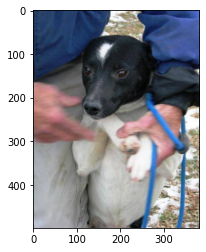

In [6]:
#Visualizando

plt.imshow(imagem_1)
plt.show()

Selectivesearch done!
Shape: (4512, 4)


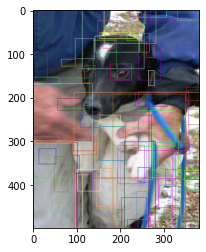

In [7]:
#visualizando as boxes:

bounding = selective_search(imagem_1, quality = True)
plot_boxes(imagem_1,bounding)

#3 - Separando as boxes em novas imagens e utilizando a VGG19 nelas:

In [8]:
#Salvar as boxes em novas imagens utilizando a imagens original e o posicionamento das boxes provindas do selective search.

boxes, recorte = get_images(imagem_1, bounding, save = False)

49152/35363 [=========================================] - 0s 0us/step


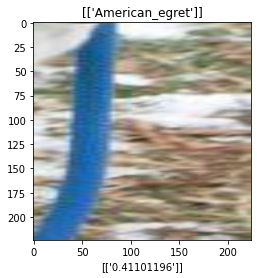

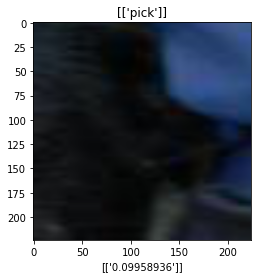

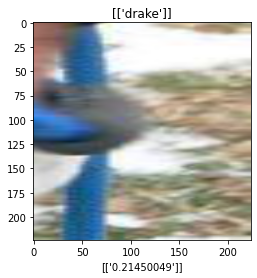

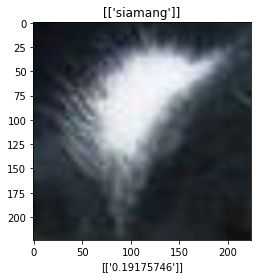

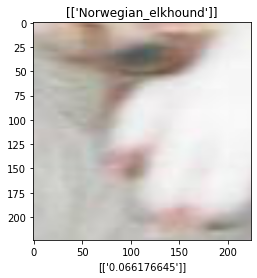

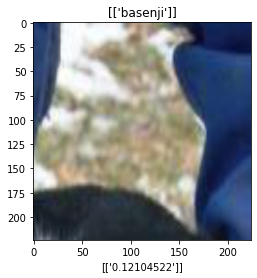

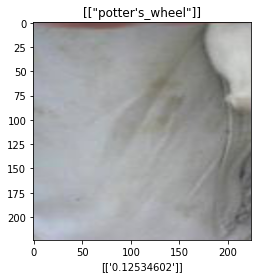

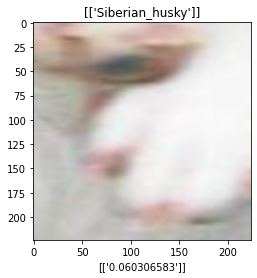

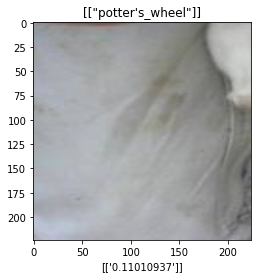

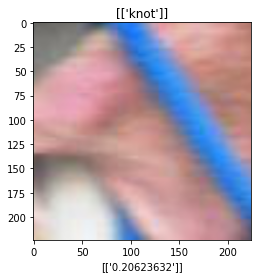

CPU times: user 22.1 s, sys: 6.17 s, total: 28.3 s
Wall time: 1min 10s


In [9]:
%%time

""" Atenção para o tamanho das imagens, inputs muito grandes faram o processo ser muito lento, recomendo um resize caso a imagem seja maior que 400x400 """

#Loop para predição:

for i in np.arange(0,10,1): #loop de 1 a 9
  input_teste = get_input(recorte[i]) #recebe a primeira e transforma para fazer o input
  predict_test = predict_model(input_teste,model = VGG19) #passa o input na função que faz predict na VGG19
  label = imagenet_utils.decode_predictions(predict_test, top = 1) #faz o decode da predição para sabermos a classe e a probabilidade
  label = np.asarray(label, dtype= str) #transforma o output num array para facilitar manipular
  label = label.reshape(-1,1,1) #opera um reshape:
  plt.xlabel(label[2]) # probabilidade
  plt.title(label[1]) # previsão:
  plt.imshow(recorte[i])
  plt.show()

In [10]:
#Executando a função que automatiza o processo.

%%time

do_it_all(images_path= '/content/drive/MyDrive/Colab Notebooks/test1/Mix/', 
          how_many = 3, #Retornará 3 predições para cada imagem.
          quality = True, #Boa qualidade de selective search
          save = True, #Salvando numa pasta específica
          plot = True) #Mostrando as imagens das predições

Output hidden; open in https://colab.research.google.com to view.

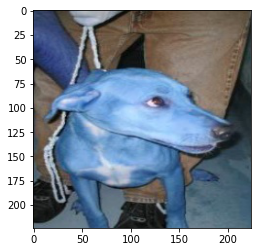

In [11]:
#Visualizando um exemplo de subimg salva durante o processo:
imagem_2 = img.imread('/content/selsearch/subimg0.jpg')
plt.imshow(imagem_2)
plt.show()

#3 - Considerações finais.

Este notebook foi feito de forma abrangente. Utilizamos aqui algumas fotos de cães e gatos desta base <a href= https://www.kaggle.com/c/dogs-vs-cats>aqui</a> .No entanto o processo pode ser feito para qualquer imagem, além de ser possível com apenas algumas mudanças de código utilizar outras redes pré-treinadas.
<br><br>
Foi uma escolha arbitrária manter a VGG19 com suas 1000 classes de avaliação disponíveis com o objetivo de entender a precisão que ela pode alcançar num universo tão vasto. Os resultados foram bem satisfatórios, em várias imagens ela pode predizer se era cão ou gato com a precisão da raça do pet na imagem. Isto não se deu de forma direta já que algumas bounding boxes recortam certos pontos da imagem em que a rede será "enganada", mas com poucas boxes podemos encontrar as predições corretas.
<br><br>
Gostaria de dar créditos também a Bruna Faria cujo Github ajudou muito a entender principalmente o processo de resize e composição das imagens nos arrays no que se trata de códigos, apesar de saber a teoria nada significa sem a prática e os exemplos encontrados lá foram fundamentais (e pouparam muitas horas de leitura de documentação). Muito obrigado Bruna! ^^.<br><br>
<a href= https://github.com/bfaria13>Link</a> para o GitHub.
